# Fine tuning distillbert

> code to fine tune a bert model specific building a search term classifier

In [ ]:
#| default_exp distilbert_fine_tuning

In [ ]:
#| hide
import sys, os
if 'google.colab' in sys.modules:
    print('Running in Google Colab')
    COLAB = True
else:
    print('Not running in Google Colab')
    from nbdev.showdoc import *
    COLAB = False

Running in Google Colab


In [ ]:
if COLAB and not os.path.exists('amz2-0.0.1-py3-none-any.whl'):
    !unzip colab.zip
    !pip install amz2-0.0.1-py3-none-any.whl # Installing package we created
    from google.colab import drive
    drive.mount('/content/drive')

In [ ]:
DEBUG = True
MODEL_PREFIX = 'drive/MyDrive/bias_no_grad/bert_' if COLAB else 'models/bert_'

!nvidia-smi

Mon Jun  5 17:06:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports

In [ ]:
#| export
import os, copy, multiprocessing, logging, gc
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import torch
from tqdm import tqdm, trange
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import warnings
from fastcore.script import call_parse, Param

#### amz2 is the package we created, which was installed with pip install amz2-0.0.1-py3-none-any.whl
from amz2.core import read_train, read_test, remap_category_index, load_int2int_dict

warnings.filterwarnings("ignore")
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
DEBUG = False
print(DEBUG)

False


In [ ]:
data = Path('data' if not COLAB else '.')
train_file = 'trainSet.csv'
test_file = 'candidateTestSet.csv' # To be read and saved to candidateTestSet.csv

train = pd.read_csv(data/train_file, header=None)
if not COLAB: test = pd.read_csv(data/test_file, header=None)
# os.listdir(data)
###############################

## Bert fine tuning

The purpose of following two cells is to simulate a true train/test split. I save `val` to "test_target.csv", and then treat `trn` as my full training set.

In [ ]:
kf = StratifiedKFold()
for fold, (trn_ind, val_ind) in enumerate(kf.split(train, train[1])):
    trn, val = train.loc[trn_ind], train.loc[val_ind]
    break
if DEBUG: trn = trn.sample(frac=.1)
# val = val.sample(frac=.05)

In [ ]:
trn.to_csv('train.csv', header=False, index=False)
val[0].to_csv('test_input.csv', header=False, index=False)
val[1].to_csv('test_target.csv', header=False, index=False)
display(read_test('test_input.csv').head(2))
del trn, val, train
gc.collect()

,st
0,yew hedge
1,fire detection shop


59

## Library

In [ ]:
def get_train_dataloader(text_list, label_list, tokenizer, batch_size=32, num_workers=0):
    encoded_dict = tokenizer.batch_encode_plus(text_list, padding=True, truncation=True, max_length=128)
    input_ids = torch.tensor(encoded_dict['input_ids'])
    attention_masks = torch.tensor(encoded_dict['attention_mask'])
    labels = torch.tensor(label_list)
    dataset = TensorDataset(input_ids, attention_masks, labels)
    if num_workers == -1: num_workers = multiprocessing.cpu_count()
    return DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

def get_test_dataloader(text_list, tokenizer, batch_size=32, num_workers=0):
    encoded_dict = tokenizer.batch_encode_plus(text_list, padding=True, truncation=True, max_length=128)
    input_ids = torch.tensor(encoded_dict['input_ids'])
    attention_masks = torch.tensor(encoded_dict['attention_mask'])
    dataset = TensorDataset(input_ids, attention_masks)
    if num_workers == -1: num_workers = multiprocessing.cpu_count()
    return DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

sigmoid = lambda x: 1 / (1 + np.exp(-x))
def binary_cross_entropy(label, preds, dim=None, no_mean=None):
    """More flexible implementation so we can get mean per target if we want."""
    epsilon = 1e-15  # add a small value to avoid taking log of zero
    preds = torch.clamp(preds, epsilon, 1 - epsilon)
    bce_loss = -(torch.log(preds) * label + torch.log(1 - preds) * (1 - label))
    if no_mean:
        return bce_loss
    if dim is not None: return torch.mean(bce_loss, dim=dim)
    return torch.mean(bce_loss)

class BertTuner:
    def __init__(
        self,
        num_labels,
        device='cuda:0',
        model=None,
        trn_dl=None,
        val_dls:list=None,
        model_prefix='bert_',
        target_list=None,
        bias_requires_grad=True,
    ):
        """A class to fine tune a bert model with the input data loaders and model."""
        self.device = device
        self.model = model.to(self.device)
        self.trn_dl = trn_dl
        self.val_dls = val_dls if val_dls else []
        self.bce_lists = [[] for _ in range(len(self.val_dls))]
        self.accuracy_lists = [[] for _ in range(len(self.val_dls))]
        self.num_labels = num_labels
        self.model_prefix = model_prefix
        self.epoch_cnt = 1
        if target_list: self.set_mean_as_bias(target_list, bias_requires_grad) # Give if you want to set mean to bias

    def set_mean_as_bias(self, target_list, bias_requires_grad=True):
        print('setting the last layer to the mean for each class')
        ohe = torch.nn.functional.one_hot(torch.tensor(target_list), num_classes=self.num_labels)
        class_mean = ohe.float().mean(dim=0)
        self.model.classifier.bias = torch.nn.Parameter(
            class_mean.detach(), requires_grad=bias_requires_grad)
        self.model.to(self.device)

    def fit(self, epochs=1, lr=2e-5, lr_finder_dict: dict=None, fit_one_cycle=False, foc_lr_mult=10):
        if lr_finder_dict: lr = self.lr_finder(**lr_finder_dict)
        model = self.model
        if fit_one_cycle:
            optimizer = torch.optim.Adam(model.parameters(), lr=lr * foc_lr_mult)
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer, max_lr=lr, steps_per_epoch=len(self.trn_dl), epochs=epochs, div_factor=foc_lr_mult)
        else:
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        for epoch in range(epochs):
            print(f'############### Epoch {self.epoch_cnt} #################')
            for batch in tqdm(self.trn_dl):
                model.train()
                batch = tuple(t.to(self.device) for t in batch)
                inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
                outputs = model(**inputs)
                loss = outputs[0]
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                if fit_one_cycle: scheduler.step()

            overall_acc = 0.0
            zipped = zip(self.bce_lists, self.accuracy_lists, self.val_dls)
            for i, (bce_list, accuracy_list, dl) in enumerate(zipped):
                bces, overall_acc = self.score_dl(dl)
                bce_list.append(bces)
                accuracy_list.append(overall_acc)
                print(f'Overall Accuracy for valid set {i}: {overall_acc}')

            # save the model
            acc_int = f'{int(round(overall_acc, 3) * 1000) :0>3}'
            self.save_model(f'{self.model_prefix}_epoch_{self.epoch_cnt}_acc_{acc_int}.pth')
            self.epoch_cnt += 1

    def score_dl(self, dl):
        """Returns binary_cross_entropy mean for each class and overall accuracy score"""
        preds, targets = self.predict(dl)
        tar_ohe = torch.nn.functional.one_hot(targets, num_classes=self.num_labels)
        bces = binary_cross_entropy(tar_ohe, preds, dim=0)
        overall_acc = accuracy_score(targets, preds.argmax(axis=1))
        return bces, overall_acc

    def predict(self, dataloader):
        """Returns torch tensor of probabilities, and torch tensor of targets if label in batch"""
        model = self.model
        model.eval()
        preds = []
        targets = []
        cnt = 0
        for batch in tqdm(dataloader):
            cnt += 1
            batch = tuple(t for t in batch)
            inputs = {'input_ids': batch[0].to(self.device), 'attention_mask': batch[1].to(self.device)}
            if len(batch) == 3: targets.append(batch[2])
            with torch.no_grad():
                logits = model(**inputs)[0]
            preds.append(logits.cpu())
        return torch.sigmoid(torch.vstack(preds)), torch.concat(targets) if targets else None

    def save_model(self, file_path='bert_model.pth'):
        torch.save(self.model.state_dict(), file_path)

    def load_model(self, file_path='bert_model.pth'):
        self.model.load_state_dict(torch.load(file_path))

    def best_epochs(self):
        return [np.vstack(ls).argmin(axis=0) for ls in self.bce_lists]

    def lr_finder(self, start_lr=1e-7, end_lr=.1, num_it=25, batches_per_it=5, offset=3):
        print('############ Finding the best learning rate ##########')
        # Save the original model parameters
        # original_params = copy.deepcopy(self.model.state_dict())
        self.save_model('tmp_state_dict')

        # Create a model optimizer and a learning rate scheduler
        optimizer = torch.optim.Adam(self.model.parameters(), lr=end_lr)
        lr_lambda = lambda x: start_lr * (end_lr/start_lr) ** (x/num_it)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

        # Create lists to store the losses and learning rates
        losses = []
        lrs = []

        # Loop through the iterations and adjust the learning rate
        for _ in trange(num_it):
            self.load_model('tmp_state_dict')
            # self.model.load_state_dict(original_params) # To test the lr fairly
            model = self.model
            lr_loss = 0
            for i, batch in enumerate(self.trn_dl):
                model.train()
                batch = tuple(t.to(self.device) for t in batch)
                inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
                outputs = model(**inputs)
                loss = outputs[0]
                loss.backward()
                lr_loss += loss.item() / batches_per_it
                optimizer.step()
                optimizer.zero_grad()
                if i == batches_per_it - 1: break
            # Save the loss and learning rate and step scheduler
            lrs.append(scheduler.get_lr()[0])
            scheduler.step()
            losses.append(lr_loss)

        # Restore the original model parameters
        self.load_model('tmp_state_dict')
        # self.model.load_state_dict(original_params)

        # Plot the loss versus the learning rate
        plt.plot(lrs, losses)
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

        min_loss_idx = max(0, np.argmin(losses) - offset)
        best_lr = lrs[min_loss_idx]
        print(f"Best learning rate: {best_lr:.2E}")
        return best_lr


In [ ]:
class BertFineTuneMethod:
    def __init__(self, **kwargs):
        """A class to wrap the general bert fine tuner, adapting it to the
        current problem. The goal is that we can use simple code to solve
        our problem such as:

        m = BertFineTuneMethod()
        m.fit('train.csv')
        pred = m.predict_str('golfing shoes')
        pred = m.predict_test_file('test.csv')
        """
        self.kwargs = kwargs

        self.batch_size = kwargs.get('batch_size', 180)
        self.dense2tar = load_int2int_dict(kwargs.get('path_dense2tar', 'dense2tar.json'))
        self.tar2dense = load_int2int_dict(kwargs.get('path_tar2dense', 'tar2dense.json'))

        self.pre_train_weights = kwargs.get('pre_train_weights', 'distilbert-base-uncased')
        self.tokenizer = AutoTokenizer.from_pretrained(self.pre_train_weights)
        self.num_labels = max(self.dense2tar.keys()) + 1
        self.model = AutoModelForSequenceClassification.from_pretrained(self.pre_train_weights, num_labels=self.num_labels)
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        default_fit_params = dict(lr_finder_dict=dict(start_lr=1e-7, end_lr=.1, num_it=25, batches_per_it=25))
        self.fit_params = kwargs.get('fit_params', default_fit_params)
        print(kwargs)

    def fit(self, path_to_train):
        path_to_remap = (remap_category_index(path_to_train, cat_col_idx=1, path_dict='category_mapper.json'))
        trn = read_train(path_to_remap)
        trn['cat'] = trn['cat'].map(self.tar2dense)
        trn_dl = get_train_dataloader(trn.st.to_list(), trn.cat.to_list(), self.tokenizer, self.batch_size)
        if not hasattr(self, 'm'):
            self.m = BertTuner(
                num_labels=self.num_labels,
                device=self.device,
                model=self.model,
                trn_dl=trn_dl,
                val_dls=None,
                model_prefix=self.kwargs.get('model_prefix', 'bert_'),
                target_list=trn.cat.tolist() if self.kwargs.get('set_bias', True) else None
            )
        else:
            self.m.trn_dl = trn_dl
        for epoch in range(self.kwargs.get('epochs', 7)):
            self.m.fit(**self.fit_params)

    def predict_test_file(self, fpath, out_path='test_predictions.csv', batch_size=None):
        if not batch_size: batch_size = self.batch_size * 2
        tst = read_test(fpath)
        tst_dl = get_test_dataloader(tst.st.to_list(), self.tokenizer, batch_size)
        preds, _ = self.m.predict(tst_dl)
        tst['cat'] = np.argmax(preds.numpy(), axis=1)
        tst['cat'] = tst['cat'].map(self.dense2tar)
        tst['cat'].to_csv(out_path, index=False, header=False)
        return preds

    def predict_str(self, x):
        encoded_input = self.tokenizer.encode_plus(
            x,
            add_special_tokens=True,
            max_length=512,  # Max length of input
            padding="max_length",
            truncation=True,
            return_tensors="pt"  # Return PyTorch tensors
        )
        input_ids = encoded_input["input_ids"].to(self.device)
        attention_mask = encoded_input["attention_mask"].to(self.device)
        with torch.no_grad():
            outputs = self.m.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).tolist()[0]
        return self.dense2tar[predictions]

    def predict_list(self, x, use_dl=False, batch_size=None):
        if not batch_size: batch_size = self.batch_size * 2
        if use_dl:
            tst_dl = get_test_dataloader(x, self.tokenizer, batch_size)
            preds, _ = self.m.predict(tst_dl)
            preds = np.argmax(preds.numpy(), axis=1)
            return list(map(lambda x: self.dense2tar[x], preds))
        else:
            return [self.predict_str(y) for y in x]

    def predict(self, x, use_dl=False):
        """predicts list of search terms or one"""
        if type(x) == str:
            return self.predict_str(x)
        if type(x) == list:
            return self.predict_list(x, use_dl)

Trainig took a very long time, so it had to be broken up into multiple training sessions, saving and loading models from google drive.

In [ ]:
####### Code to clear out colab storage space when starting a new model ##########
# import os
# print('clearing test run model saves')
# import shutil
# parent = os.path.split(MODEL_PREFIX)[0]
# print(parent)
# if os.path.exists(parent): shutil.rmtree(parent)
# os.makedirs(parent, exist_ok=True)

In [ ]:
############ Code to run when training a model from scratch ##########
# kwargs = {
#     'model_prefix': MODEL_PREFIX,

#     # Training data mean will be set as last bias, but not trainable with False setting
#     'bias_requires_grad': False,
# }
# m = BertFineTuneMethod(**kwargs)
# m.fit('train.csv')

In [ ]:
######## Code for continued training ############

print('Setting up state of model')
parent = os.path.split(MODEL_PREFIX)[0]

ep = sorted([(int(x.split('_')[3]), x) for x in os.listdir(parent)])
last_epoch, state_dict = ep[-1]
print(state_dict)
state_dict = os.path.join(parent, state_dict)
epoch_cnt = last_epoch + 1
print(state_dict, 'epoch_cnt: ', epoch_cnt )

m = BertFineTuneMethod()
m.m = BertTuner(0, model=m.model)
m.m.load_model(state_dict)
m.m.epoch_cnt = epoch_cnt
m.m.model_prefix = MODEL_PREFIX
m.batch_size = 180 ########## Batch size #################
print('model prefix: ', m.m.model_prefix)

Setting up state of model
bert__epoch_14_acc_000.pth
drive/MyDrive/bias_no_grad/bert__epoch_14_acc_000.pth epoch_cnt:  15
{}
model prefix:  drive/MyDrive/bias_no_grad/bert_


batches_per_it: 25

loading in train.csv, remapping column index 1,
    and saving the resuling df to train_remapped.csv

############ Finding the best learning rate ##########


100%|██████████| 25/25 [04:52<00:00, 11.70s/it]


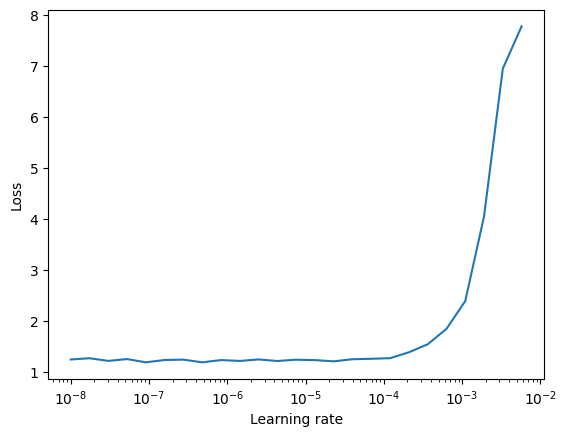

Best learning rate: 1.74E-08
############### Epoch 15 #################


100%|██████████| 2697/2697 [20:45<00:00,  2.16it/s]


############ Finding the best learning rate ##########


100%|██████████| 25/25 [04:52<00:00, 11.71s/it]


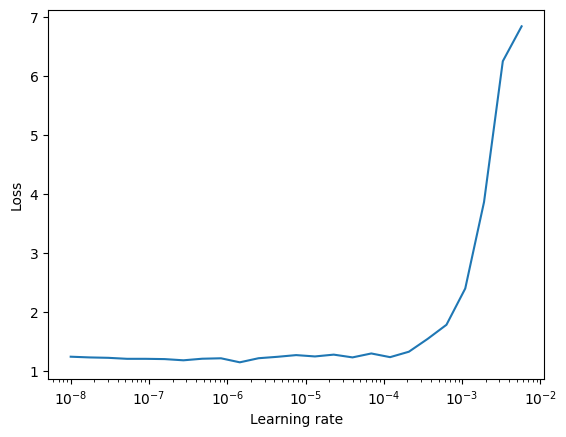

Best learning rate: 2.75E-07
############### Epoch 16 #################


100%|██████████| 2697/2697 [20:45<00:00,  2.17it/s]


############ Finding the best learning rate ##########


100%|██████████| 25/25 [04:52<00:00, 11.71s/it]


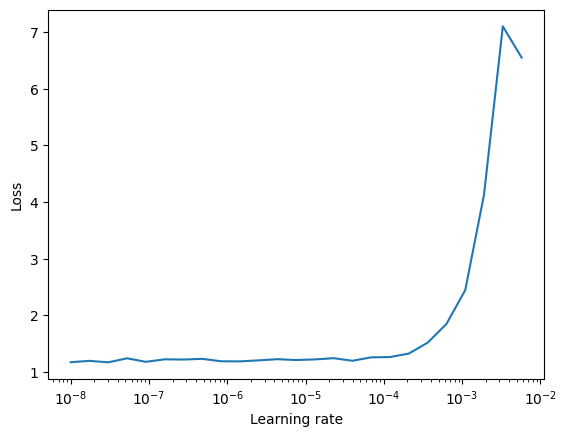

Best learning rate: 1.00E-08
############### Epoch 17 #################


100%|██████████| 2697/2697 [20:45<00:00,  2.16it/s]


In [ ]:
samples_seen_per_iteration = 25 * 180
batches_per_it = samples_seen_per_iteration // m.batch_size
print(f'batches_per_it: {batches_per_it}')
m.fit_params = dict(lr_finder_dict=dict(
    start_lr=1e-7, end_lr=.1, num_it=25, batches_per_it=batches_per_it))
m.kwargs['epochs'] = 3
m.fit('train.csv')


loading in train.csv, remapping column index 1,
    and saving the resuling df to train_remapped.csv

############ Finding the best learning rate ##########


100%|██████████| 25/25 [04:52<00:00, 11.72s/it]


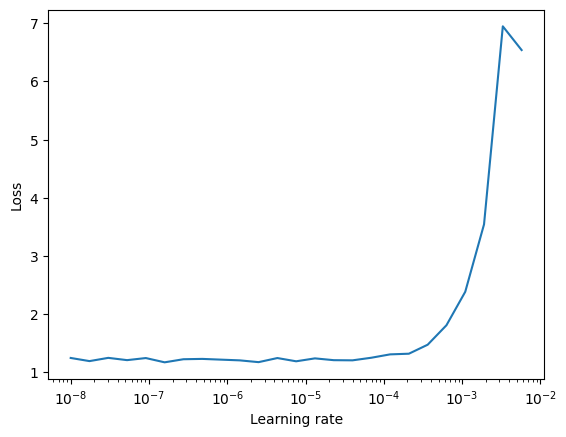

Best learning rate: 3.02E-08
############### Epoch 18 #################


100%|██████████| 2697/2697 [20:45<00:00,  2.17it/s]


############ Finding the best learning rate ##########


100%|██████████| 25/25 [04:52<00:00, 11.71s/it]


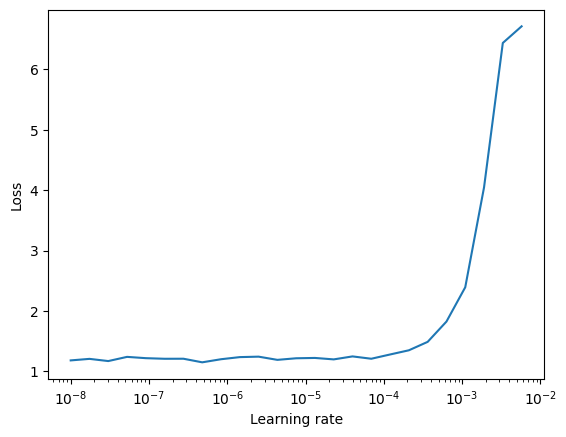

Best learning rate: 9.12E-08
############### Epoch 19 #################


100%|██████████| 2697/2697 [20:45<00:00,  2.17it/s]


############ Finding the best learning rate ##########


100%|██████████| 25/25 [04:52<00:00, 11.71s/it]


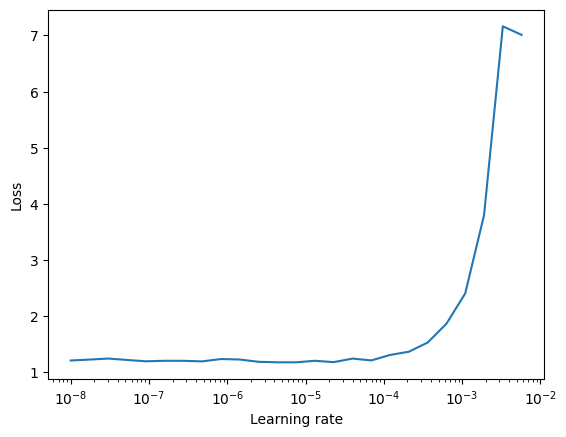

Best learning rate: 1.45E-06
############### Epoch 20 #################


100%|██████████| 2697/2697 [20:44<00:00,  2.17it/s]


In [ ]:
m.fit('train.csv')


loading in train.csv, remapping column index 1,
    and saving the resuling df to train_remapped.csv

############ Finding the best learning rate ##########


100%|██████████| 25/25 [04:52<00:00, 11.72s/it]


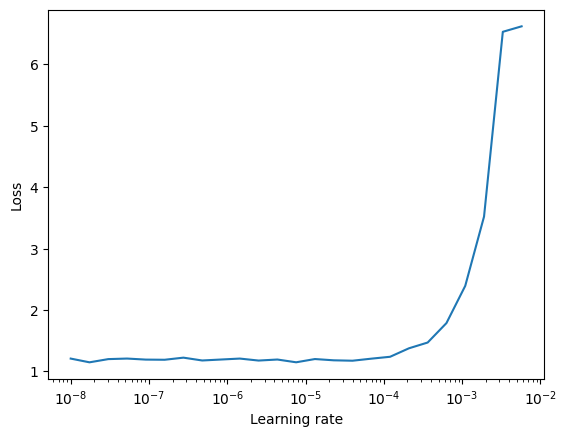

Best learning rate: 1.00E-08
############### Epoch 21 #################


 98%|█████████▊| 2631/2697 [20:15<00:30,  2.17it/s]

In [ ]:
m.fit('train.csv')

{'model_prefix': 'drive/MyDrive/bias_no_grad/bert_', 'bias_requires_grad': False}

loading in train.csv, remapping column index 1,
    and saving the resuling df to train_remapped.csv

setting the last layer to the mean for each class


In [ ]:
m.predict_list(['alkjf', 'whats up', 'lkdjflsakdjf'], use_dl=True)

In [ ]:
 m.predict_list(['alkjf', 'whats up', 'lkdjflsakdjf'], use_dl=False)

In [ ]:
m.predict_str('hello')

In [ ]:
#| hide
# import nbdev; nbdev.nbdev_export()